## Copyright

####Copyright 2021 DeepMind Technologies Limited. All Rights Reserved.
####Licensed under the Apache License, Version 2.0 (the "License");

####Full license text

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural Testbed

![](https://colab.research.google.com/github/deepmind/neural_testbed/blob/master/neural_testbed/statics/images/neural_testbed_logo.png)


https://bit.ly/neural_testbed_tutorial


The Neural Testbed provides tools for the systematic evaluation of agents that generate predictions.
Crucially, these tools assess not only the quality of the marginal predictions per input, but also joint predictions given many inputs.

- This notebook is designed to help you get up to speed on the [open source code](https://github.com/deepmind/neural_testbed).
- You can read more about the project via the [arXiv paper](https://arxiv.org/abs/2110.04629).


## Installation

In this section we will use `pip` to install `neural_testbed`.

Make sure that you are running a Python 3 runtime.

In [ ]:
#@title Installing neural_testbed
!git clone https://github.com/deepmind/neural_testbed.git
!pip install -q neural_testbed/

## Import

In [ ]:
#@title General imports
from typing import Callable, NamedTuple

import numpy as np
import pandas as pd
import plotnine as gg

# from acme.utils.loggers.terminal import TerminalLogger
import dataclasses
import chex
import haiku as hk
import jax
import jax.numpy as jnp
import optax

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#@title Neural Testbed imports 
import neural_testbed
from neural_testbed.agents import factories as agent_factories
from neural_testbed import base
from neural_testbed import generative
from neural_testbed import leaderboard

## High level overview

Neural Testbed relies on two high level concepts:

1. **`TestbedProblem`**: A `TestbedProblem` is a problem with three components:
  - `train_data`: provides the tuple (X, Y) of train data.
  - `prior_knowledge`: describes information (e.g., input dimension, number of classes, etc) about the problem.
  - `evaluate_quality`: evaluates the quality of a posterior distribution.

2. **`TestbedAgent`**: A `TestbedAgent` is an agent which takes `train_data` and `prior_knowledge` and returns an `EpistemicSampler`. The `EpistemicSampler` outputs an approximate posterior sample at a given data `x` and a given random `key`. The output sample provides logits for each of problem's classes.

Neural Tesbed defines 420 classification problems where each problem is identified by a string identifier called `problem_id`.

Each `problem_id` is constructed by concatenating `classification_2d/` and a number ranging from 0 to 419. 

The valid `problem_id`s are defined in `leaderboard.CLASSIFICATION_2D`.

In [ ]:
#@title Valid problem_id problems:
print('All possible values for problem_id:', leaderboard.CLASSIFICATION_2D)

All possible values for gp_id: ('classification_2d/0', 'classification_2d/1', 'classification_2d/2', 'classification_2d/3', 'classification_2d/4', 'classification_2d/5', 'classification_2d/6', 'classification_2d/7', 'classification_2d/8', 'classification_2d/9', 'classification_2d/10', 'classification_2d/11', 'classification_2d/12', 'classification_2d/13', 'classification_2d/14', 'classification_2d/15', 'classification_2d/16', 'classification_2d/17', 'classification_2d/18', 'classification_2d/19', 'classification_2d/20', 'classification_2d/21', 'classification_2d/22', 'classification_2d/23', 'classification_2d/24', 'classification_2d/25', 'classification_2d/26', 'classification_2d/27', 'classification_2d/28', 'classification_2d/29', 'classification_2d/30', 'classification_2d/31', 'classification_2d/32', 'classification_2d/33', 'classification_2d/34', 'classification_2d/35', 'classification_2d/36', 'classification_2d/37', 'classification_2d/38', 'classification_2d/39', 'classification_2d

Neural Tesbed also contains the implementation of benchmark agents.

Implemented benchmark agents are defined in `agents/factories`.

In [ ]:
#@title Implemented agents:
print('All implemeted agents:', agent_factories.get_implemented_agents())

All implemeted agents: ['baseline:uniform_class_probs', 'baseline:average_class_probs', 'baseline:prior', 'logistic_regression', 'mlp', 'bbb', 'vanilla_ensemble', 'ensemble_plus', 'hypermodel', 'mc_dropout', 'sgmcmc', 'deep_kernel', 'knn', 'random_forest']


Neural Testbed also provides utilities for developing new `TestbedAgent`s. 

You can define your own `TestbedAgent` based on the interface specified in  [base.py](https://github.com/deepmind/neural_testbed/blob/master/neural_testbed/base.py):

```
class EpistemicSampler(typing_extensions.Protocol):
  """Interface for drawing posterior samples from distribution."""

  def __call__(self, x: chex.Array, key: chex.PRNGKey) -> chex.Array:
    """Generate a random sample from approximate posterior distribution."""


class TestbedAgent(typing_extensions.Protocol):
  """An interface for specifying a testbed agent."""

  def __call__(self, data: Data, prior: PriorKnowledge) -> EpistemicSampler:
    """Provides training data and prior knowledge to the testbed agent.""
```

As an example, below we define an agent that
- ignores the training data.
- always outputs equal logits for all classes regardless of what input data 'x' is.
- behaves deterministically and ignores the random `key`.

In [ ]:
#@title Define a uniform class probabilites agent
def make_uniform_class_prob_agent(
      data: base.Data,
      prior: base.PriorKnowledge,
  ) -> base.EpistemicSampler:
  del data  # data does not affect the agent.
  def enn_sampler(x: chex.Array, key: chex.PRNGKey) -> chex.Array:
    del key  # key does not affect the agent.
    return jnp.ones([x.shape[0], prior.num_classes]) / prior.num_classes
  return enn_sampler

## Evaluating an agent on a problem

We consider a problem with `problem_id=classification_2d/144` which is a problem with
- input dimension = 2
- number of train data = 10
- number of classes = 2
- temperature = 0.1
- tau = 1




In [ ]:
#@title Details of the configuration of the problem:
leaderboard.SETTINGS['classification_2d/144']

ProblemConfig(prior_knowledge=PriorKnowledge(input_dim=2, num_train=10, tau=1, num_classes=2, layers=2, noise_std=None, temperature=0.1, extra=None), seed=145, num_test_seeds=1000, num_enn_samples=1000, num_test_cache=1000, epistemic_only=False)

In [ ]:
#@title Create the problem
problem = leaderboard.problem_from_id('classification_2d/144')

### Example 1: Uniform baseline agent

While we can access this agent (called `baseline:uniform_class_probs`) from `agents/factories`, here we use `make_uniform_class_prob_agent` function we defined above.

In [ ]:
#@title Running uniform baseline agent on the problem
agent = make_uniform_class_prob_agent
enn_sampler = agent(problem.train_data, problem.prior_knowledge)

We can evaluates the quality of `enn_sampler` with `problem.evaluate_quality`. In addition to KL estimate, it provides extra information like train and test accuracies.

In [ ]:
#@title Evaluating quality of the agent
problem.evaluate_quality(enn_sampler)

ENNQuality(kl_estimate=DeviceArray(0.4991302, dtype=float32), extra={'kl_estimate_std': 0.4661790132522583, 'train_acc': 0.20000000298023224, 'test_acc': 0.1988012045621872, 'train_ece': 0.30000001192092896, 'test_ece': 0.3011987805366516})

Neural Testbed provides some functionalities for visualizing the `enn_sampler` returned by the agent. 

They can be accessed from `generative/plotting`.

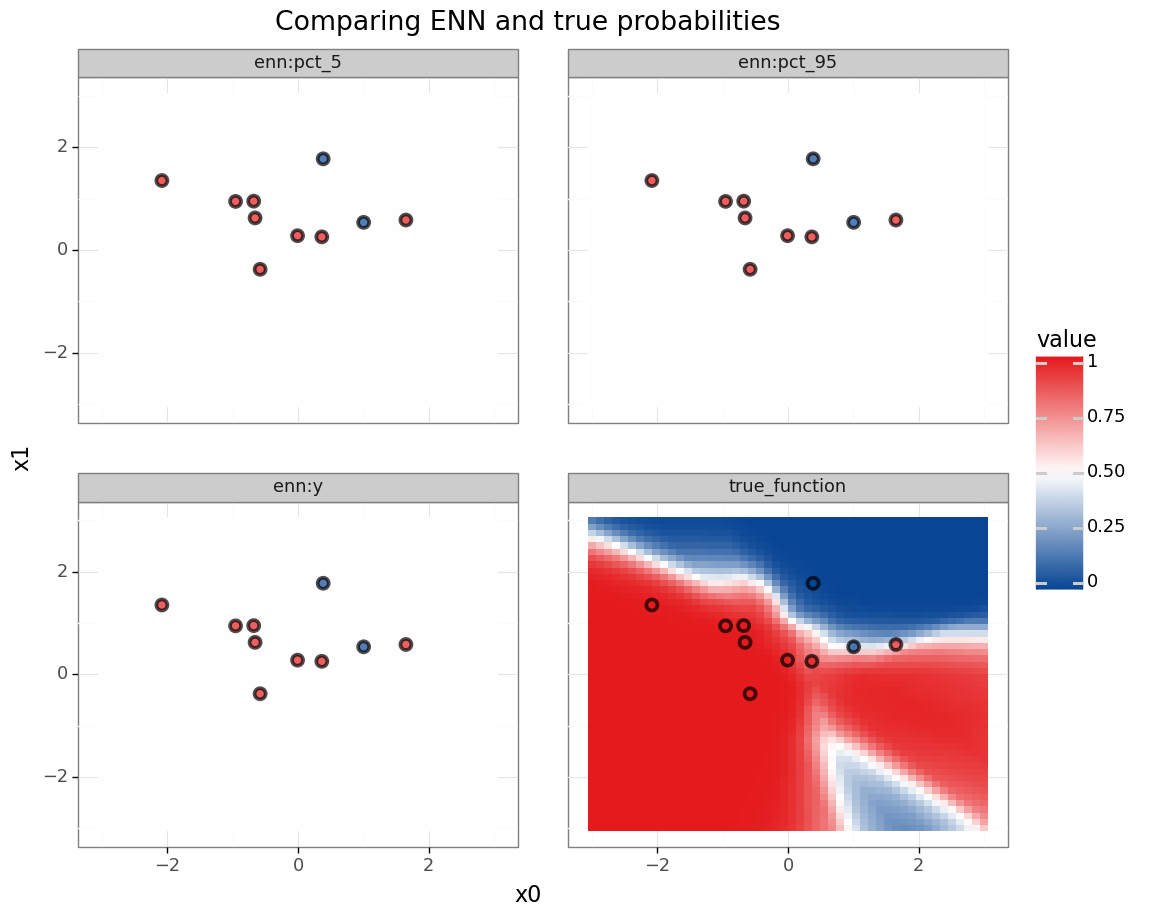

<ggplot: (8748407539453)>

In [ ]:
#@title Plot comparing ENN and true function with pct_5, pct_95
plots = generative.sanity_plots(problem, enn_sampler)
plots['more_enn']

### Example 2: Ensemble agent

This agent (called `vanilla_ensemble`) can be accessed from `agents/factories`. This is an agent:
  - with ensemble of MLP networks.
  - where each network is trained independently with its own perturbed data.

The default configuration of this agent is defined at `agents/factories/ensemble`.

We can also change the configuration easily.

In [ ]:
#@title Default configuration of ensemble agent
agent_factories.ensemble.VanillaEnsembleConfig()

VanillaEnsembleConfig(num_ensemble=100, l2_weight_decay=1.0, adaptive_weight_scale=True, hidden_sizes=(50, 50), num_batches=1000, seed=0)

In [ ]:
#@title Changing the number of ensembles in the default configuration of ensemble agent
ensemble_config = agent_factories.ensemble.VanillaEnsembleConfig()
ensemble_config.num_ensemble = 30

In [ ]:
#@title Running ensemble agent on the problem
paper_agent = agent_factories.get_paper_agent('ensemble')
agent = paper_agent.ctor(ensemble_config)
enn_sampler = agent(problem.train_data, problem.prior_knowledge)


[Experiment] Acc:Accuracy = 0.8133333921432495 | Acc:Loss = 0.18666663765907288 | Dataset = train | Decay = 3.9728827476501465 | Loss = 4.479403972625732 | Raw Loss = 0.5065210461616516 | Sgd = True | Step = 33 | Trainer = loss
[Experiment] Acc:Accuracy = 0.8600000143051147 | Acc:Loss = 0.13999998569488525 | Dataset = train | Decay = 3.2251579761505127 | Loss = 3.650024175643921 | Raw Loss = 0.42486628890037537 | Sgd = True | Step = 66 | Trainer = loss
[Experiment] Acc:Accuracy = 0.8799999952316284 | Acc:Loss = 0.12000002712011337 | Dataset = train | Decay = 2.687654495239258 | Loss = 3.075772285461426 | Raw Loss = 0.38811779022216797 | Sgd = True | Step = 99 | Trainer = loss
[Experiment] Acc:Accuracy = 0.8966666460037231 | Acc:Loss = 0.10333336144685745 | Dataset = train | Decay = 2.2932746410369873 | Loss = 2.6393871307373047 | Raw Loss = 0.34611257910728455 | Sgd = True | Step = 132 | Trainer = loss
[Experiment] Acc:Accuracy = 0.8966666460037231 | Acc:Loss = 0.10333336144685745 | Da

In [ ]:
#@title Evaluating quality of the agent
problem.evaluate_quality(enn_sampler)

ENNQuality(kl_estimate=DeviceArray(0.17524229, dtype=float32), extra={'kl_estimate_std': 0.40092918276786804, 'train_acc': 0.800000011920929, 'test_acc': 0.8011987805366516, 'train_ece': 0.17225541174411774, 'test_ece': 0.09099360555410385})

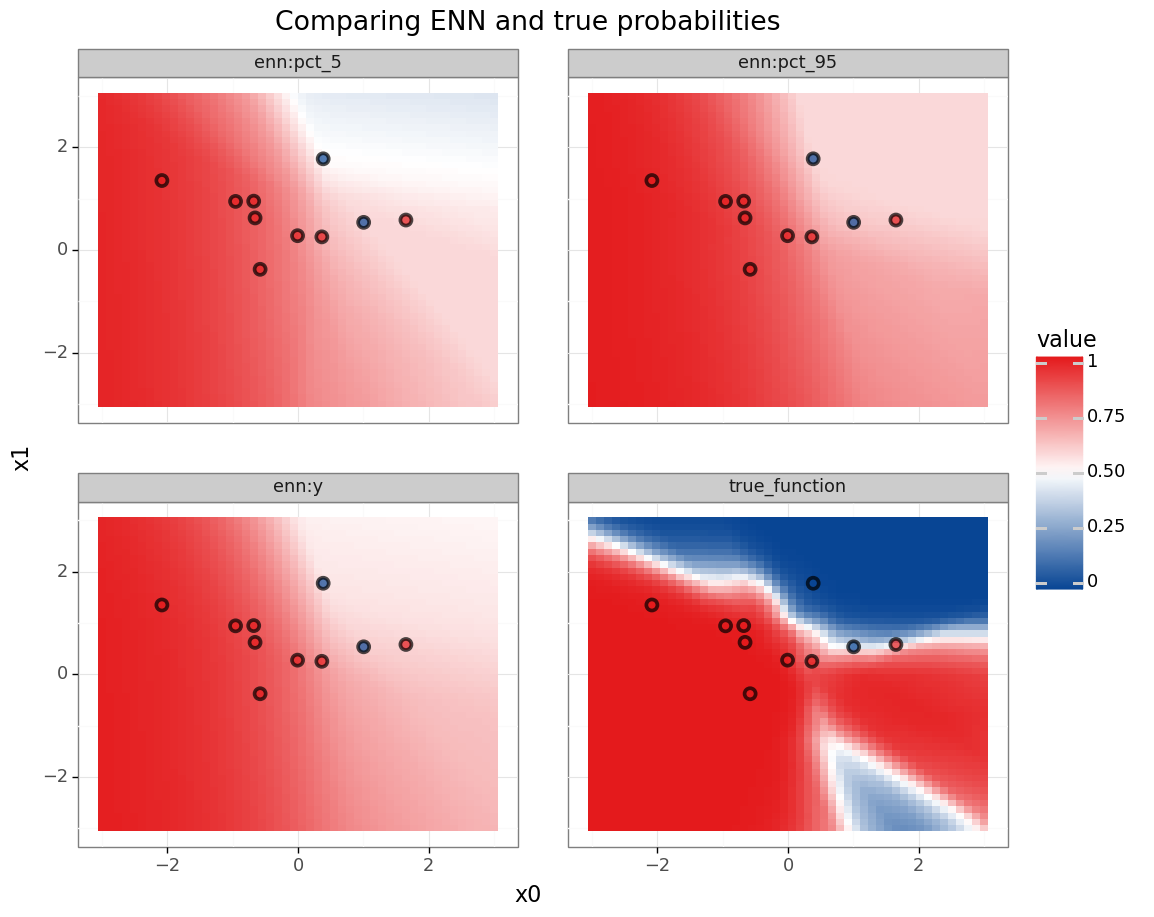

<ggplot: (8748397880113)>

In [ ]:
#@title Plot comparing ENN and true function with pct_5, pct_95
plots = generative.sanity_plots(problem, enn_sampler)
plots['more_enn']

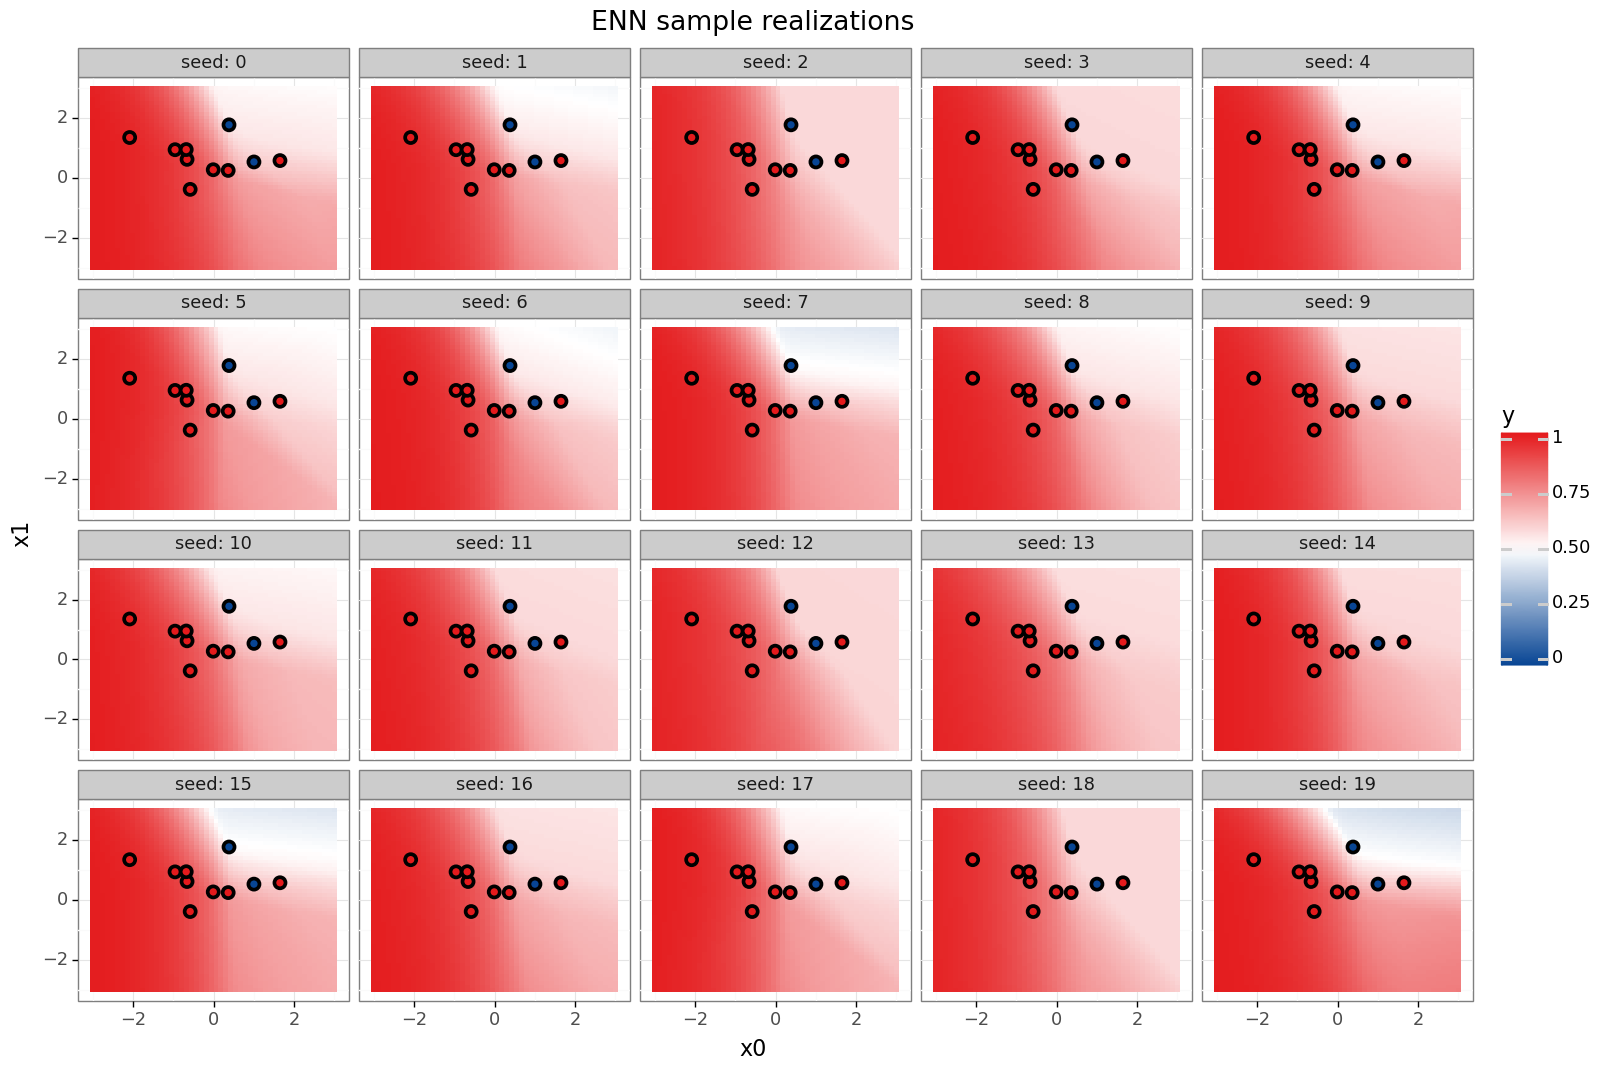

<ggplot: (8748397835601)>

In [ ]:
#@title Plot realizations of enn samples
plots['sample_enn']

### Example 3: Ensemble+ agent

This agent (called `ensemble_plus`) can be accessed from `agents/factories`. This is an agent:
  - with ensemble of MLP networks.
  - with randomized  prior  functions and bootstrap sampling.
  - where each network is trained independently with its own perturbed data.


The default configuration of this agent is defined at `agents/factories/ensemble_plus`.

We can also change the configuration easily.

In [ ]:
#@title Default configuration of ensemble+ agent
agent_factories.ensemble_plus.EnsembleConfig()

EnsembleConfig(num_ensemble=100, l2_weight_decay=1.0, adaptive_weight_scale=True, distribution='none', prior_scale=3.0, temp_scale_prior='sqrt', hidden_sizes=(50, 50), num_batches=1000, seed=0)

In [ ]:
#@title Changing the number of ensembles in the default configuration of ensemble+ agent
ensemble_plus_config = agent_factories.ensemble_plus.EnsembleConfig()
ensemble_plus_config.num_ensemble = 30

In [ ]:
#@title Running ensemble+ agent on the problem
paper_agent = agent_factories.get_paper_agent('ensemble+')
agent = paper_agent.ctor(ensemble_plus_config)
enn_sampler = agent(problem.train_data, problem.prior_knowledge)


[Experiment] Acc:Accuracy = 0.5033333897590637 | Acc:Loss = 0.49666664004325867 | Dataset = train | Decay = 5.186830520629883 | Loss = 7.187498569488525 | Raw Loss = 2.0006680488586426 | Sgd = True | Step = 33 | Trainer = loss
[Experiment] Acc:Accuracy = 0.6666666865348816 | Acc:Loss = 0.3333333134651184 | Dataset = train | Decay = 4.466639041900635 | Loss = 5.419960975646973 | Raw Loss = 0.9533218741416931 | Sgd = True | Step = 66 | Trainer = loss
[Experiment] Acc:Accuracy = 0.6733333468437195 | Acc:Loss = 0.3266666829586029 | Dataset = train | Decay = 3.9350645542144775 | Loss = 4.707159996032715 | Raw Loss = 0.7720953226089478 | Sgd = True | Step = 99 | Trainer = loss
[Experiment] Acc:Accuracy = 0.7933333516120911 | Acc:Loss = 0.20666664838790894 | Dataset = train | Decay = 3.514268398284912 | Loss = 3.890312671661377 | Raw Loss = 0.37604424357414246 | Sgd = True | Step = 132 | Trainer = loss
[Experiment] Acc:Accuracy = 0.8233333826065063 | Acc:Loss = 0.17666660249233246 | Dataset =

In [ ]:
#@title Evaluating quality of the agent
problem.evaluate_quality(enn_sampler)

ENNQuality(kl_estimate=DeviceArray(0.13994612, dtype=float32), extra={'kl_estimate_std': 0.32910528779029846, 'train_acc': 0.8999999761581421, 'test_acc': 0.867132842540741, 'train_ece': 0.10529716312885284, 'test_ece': 0.08729127049446106})

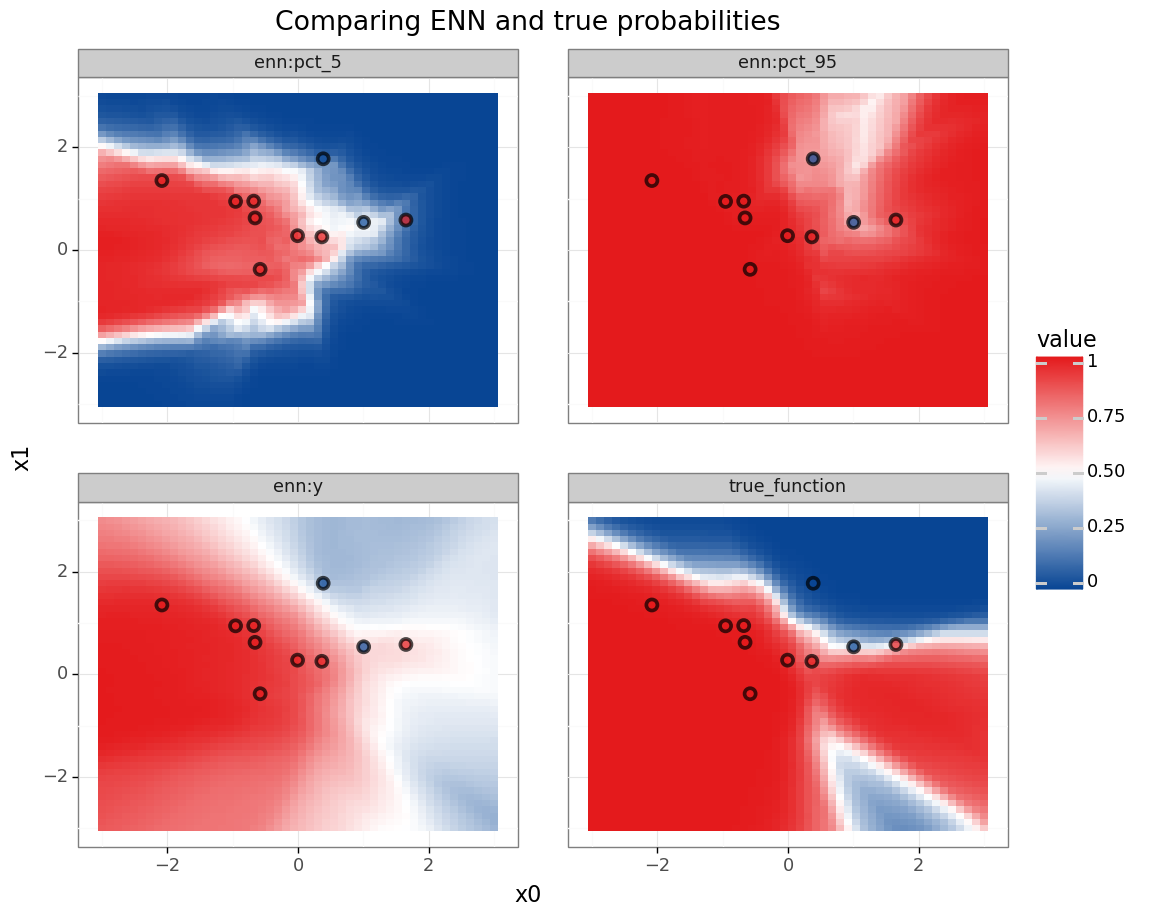

<ggplot: (8748392411125)>

In [ ]:
#@title Plot comparing ENN and true function with pct_5, pct_95
plots = generative.sanity_plots(problem, enn_sampler)
plots['more_enn']

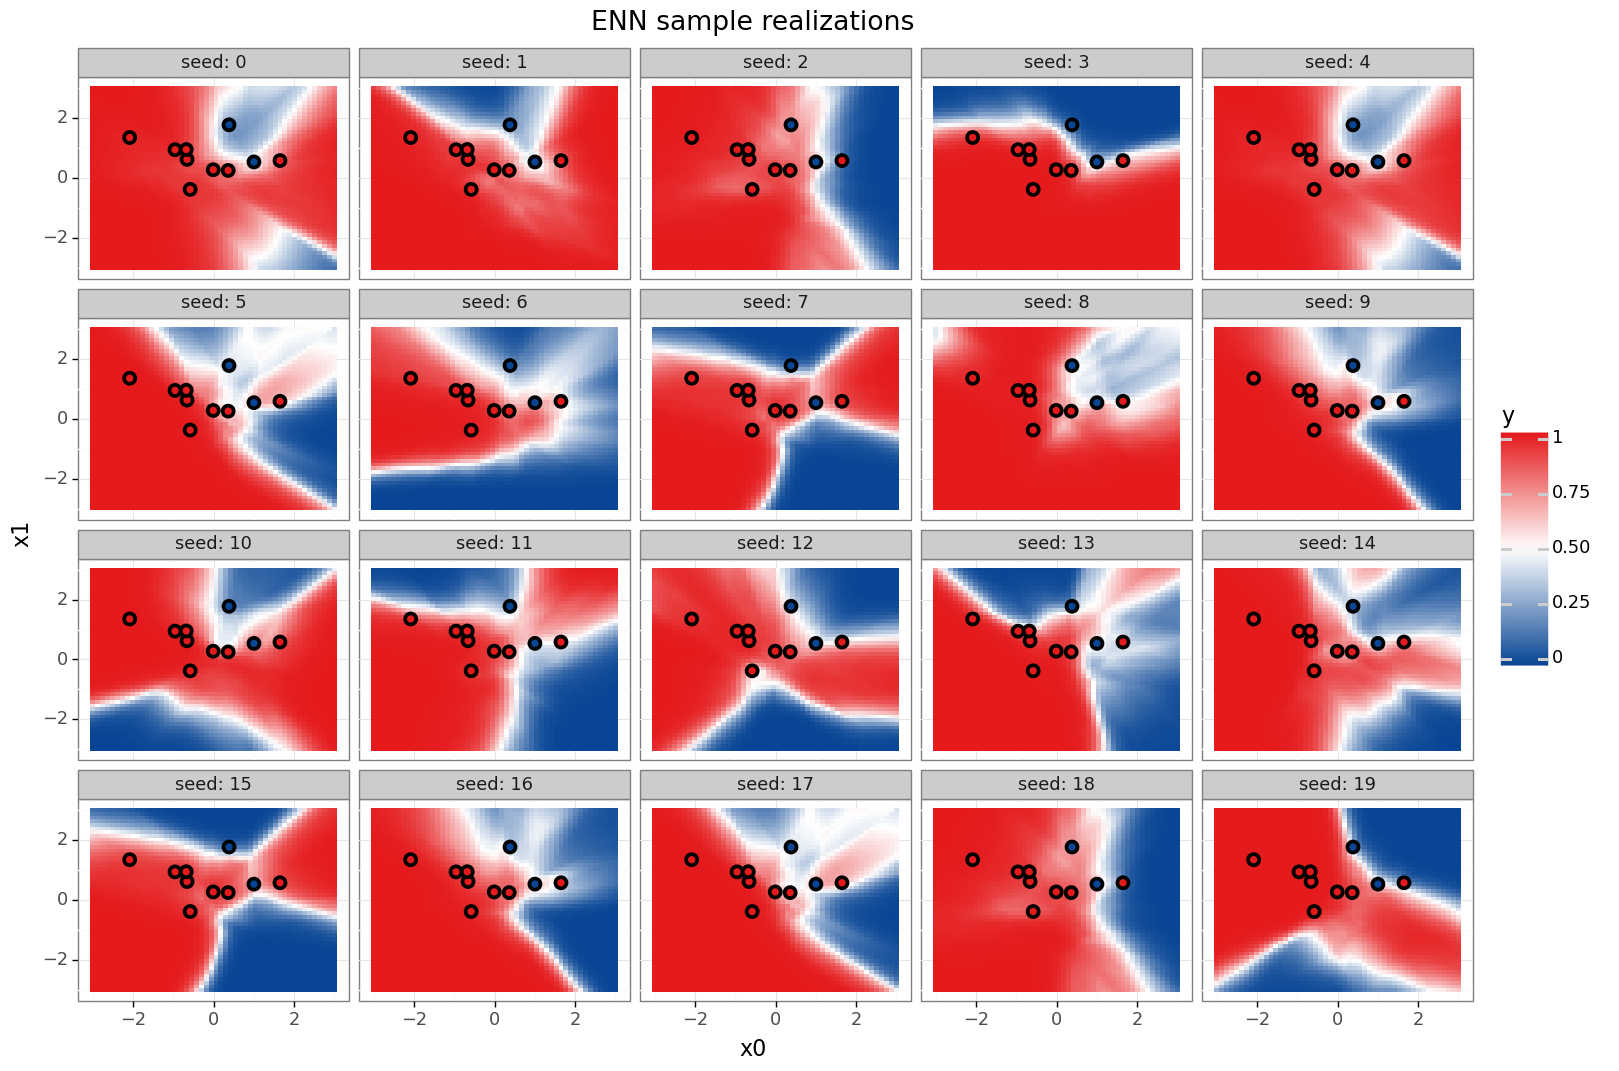

<ggplot: (8748392282109)>

In [ ]:
#@title Plot realizations of enn samples
plots['sample_enn']

## Evaluating an agent across a sweep

In order to evaluate and compare an agent systematically, we collect different `problem_id` to form a specified "sweep" = fixed collection of `problem_id`.
When you load the `problem_from_id_csv` these results are automatically saved to csv file specified by `results_dir`.

For the results in the [paper](https://arxiv.org/abs/2110.04629), you should evaluate an agent across `CLASSIFICATION_2D`, which includes several seeds, data regimes and SNR regimes.
For the purposes of this demo/tutorial, we will show how to run an agent across a reduced subset of this sweep defined by `CLASSIFICATION_2D_TEST` (which includes many fewer problem instances).

In [ ]:
#@title Small sweep of problem settings for demo/testing
leaderboard.CLASSIFICATION_2D_TEST

('classification_2d_test/0',
 'classification_2d_test/1',
 'classification_2d_test/2',
 'classification_2d_test/3',
 'classification_2d_test/4',
 'classification_2d_test/5',
 'classification_2d_test/6')

In [ ]:
#@title Evaluate the agents across this leaderboard
%max_output_height 200
for agent_name in ['baseline:uniform_class_probs', 'mlp']:
  paper_agent = agent_factories.get_paper_agent(agent_name)
  agent = paper_agent.ctor(paper_agent.default)
  results_dir = f'/tmp/neural_testbed/{agent_name}/'

  for problem_id in leaderboard.CLASSIFICATION_2D_TEST:
    print(f'Running agent={agent_name} on problem={problem_id}...')
    problem = leaderboard.problem_from_id_csv(
        problem_id, results_dir, overwrite=True)
    enn_sampler = agent(problem.train_data, problem.prior_knowledge)
    _ = problem.evaluate_quality(enn_sampler) 


Running agent=baseline:uniform_class_probs on problem=classification_2d_test/0...
Running agent=baseline:uniform_class_probs on problem=classification_2d_test/1...
Running agent=baseline:uniform_class_probs on problem=classification_2d_test/2...
Running agent=baseline:uniform_class_probs on problem=classification_2d_test/3...
Running agent=baseline:uniform_class_probs on problem=classification_2d_test/4...
Running agent=baseline:uniform_class_probs on problem=classification_2d_test/5...
Running agent=baseline:uniform_class_probs on problem=classification_2d_test/6...
Running agent=mlp on problem=classification_2d_test/0...
[Experiment] Acc:Accuracy = 1.0 | Acc:Loss = 0.0 | Dataset = train | Decay = 13.734640121459961 | Loss = 13.906464576721191 | Raw Loss = 0.17182475328445435 | Sgd = True | Step = 33 | Trainer = loss
[Experiment] Acc:Accuracy = 1.0 | Acc:Loss = 0.0 | Dataset = train | Decay = 11.138317108154297 | Loss = 11.254980087280273 | Raw Loss = 0.11666343361139297 | Sgd = True 

In [ ]:
#@title To load entries with data validation we form a leaderboard.Entry
uniform_entry = leaderboard.Entry(
    name='baseline:uniform_class_probs',
    results_dir='/tmp/neural_testbed/agent_comparison_v2/baseline:uniform_class_probs/',
)
mlp_entry = leaderboard.Entry(
    name='mlp',
    results_dir='/tmp/neural_testbed/agent_comparison_v2/mlp/',
)

In [ ]:
#@title Loading this data validates that entries include all `problem_id`
data = leaderboard.load_entries_csv(
    leaderboard_entries=[uniform_entry, mlp_entry],
    leaderboard_sweep=leaderboard.CLASSIFICATION_2D_TEST,
    verbose=True,
)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Cleaning data for agent = baseline:uniform_class_probs

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Cleaning data for agent = mlp


In [ ]:
#@title Display the average performance per agent, normalized with uniform=1
leaderboard.display_ranking_df(data)

,agent_name,normalized_kl,normalized_stderr,mean_test_acc,mean_train_seconds,mean_evaluation_seconds
0,mlp,0.272725,0.053456,0.925931,2.581486,16.622127
1,baseline:uniform_class_probs,1.000000,0.009750,0.342657,0.000013,10.448354
